## Importing modules

In [2]:
!pip install mxnet

     |████████████████████████████████| 55.0 MB 59 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import os

import io
import sagemaker.amazon.common as smac
import sagemaker
import boto3
from sagemaker import get_execution_role

import matplotlib.pyplot as plt
from IPython.display import display
import mxnet as mx
import numpy as np
from scipy.spatial.distance import cdist
import sklearn.metrics

## Loading data

In [8]:
df = pd.read_csv('../data/dataset_transformed.csv')
df = df.set_index('DNI')

In [9]:
df.head()

,EDAD,ING_ESTIMADO_6,coef_var_ing,peso_consumo,peso_cons_rank1,peso_cons_rank2,peso_cons_rank3,peso_cons_rank4,peso_cons_rank5,RECENCIA_RANK1,...,peso_cup_prom,CANTADICIONALES,Max_atraso,cant_recat_oblig_3m,vl_deuda_sist_total,rel_deud_ingest,nu_entidades_TC,nu_entidades,cd_entidad_principal,total_reclamos_3M
DNI,,,,,,,,,,,,,,,,,,,,,
39328961,28.0,664.0,0.227139,1.0,0.311392,0.287642,0.260461,0.112005,0.017780,18.0,...,0.047619,0,0.0,0.0,926.0,1.367799,1.0,3.0,7.0,4.0
7883162,72.0,555.0,0.119632,1.0,0.504417,0.192759,0.141181,0.094142,0.067501,0.0,...,0.000000,3,0.0,0.0,2588.0,4.731261,1.0,3.0,285.0,5.0
16777911,56.0,329.0,0.494983,1.0,0.608982,0.146134,0.064871,0.064201,0.040786,29.0,...,0.000000,0,0.0,0.0,1544.0,2.058667,1.0,3.0,330.0,4.0
11912293,64.0,229.0,0.166667,1.0,0.546834,0.380577,0.041031,0.031558,0.000000,30.0,...,0.000000,0,0.0,0.0,118.0,0.414035,1.0,1.0,70408.0,10.0
39022602,24.0,452.0,0.148607,1.0,0.356685,0.327605,0.155974,0.134291,0.025445,26.0,...,0.000000,1,0.0,0.0,603.0,1.308026,1.0,1.0,70408.0,3.0


In [10]:
df.isna().sum().sum()

0

In [11]:
# S3 bucket and prefix
bucket = 'dev-analitica-develop' # '<user-data-bucket>' # replace with your bucket name'
prefix = 'cluster_experiencia/data'

role = get_execution_role()

In [12]:
df_wo_transforms = df.copy()

In [13]:
df_wo_transforms.columns

Index(['EDAD', 'ING_ESTIMADO_6', 'coef_var_ing', 'peso_consumo',
       'peso_cons_rank1', 'peso_cons_rank2', 'peso_cons_rank3',
       'peso_cons_rank4', 'peso_cons_rank5', 'RECENCIA_RANK1',
       'RECENCIA_RANK_2', 'RECENCIA_RANK3', 'RECENCIA_RANK_4',
       'RECENCIA_RANK_5', 'CUPONES_RANK1', 'CUPONES_RANK2', 'CUPONES_RANK3',
       'CUPONES_RANK4', 'CUPONES_RANK5', 'Q_COMPRAS_WEB_3M', 'Q_ACCESO_APP_3M',
       'Q_ACCESO_NOL_3M', 'Q_PAGO_ELECTRONICO_3M', 'Q_RCD_LEIDO_3M',
       'Q_LLAMADAS_3M', 'Q_PAGO_SUC_3M', 'Q_PAGO_TERCERO_3M',
       'Q_FISICO_VISITAS_3M', 'Total_Contactos', 'peso_gest_digitales',
       'peso_gest_fisico', 'peso_gest_llamadas', 'ANTIGUEDAD',
       'Q_Rechazos_Deuda', 'Q_Rechazos_Limites', 'DEUDA_TOTAL',
       'FINAN_HASTA_6', 'FINAN_MAS_6', 'FINAN_ZETA', 'peso_cup_prom',
       'CANTADICIONALES', 'Max_atraso', 'cant_recat_oblig_3m',
       'vl_deuda_sist_total', 'rel_deud_ingest', 'nu_entidades_TC',
       'nu_entidades', 'cd_entidad_principal', 'total_rec

## General transformations for clustering

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

## Dimensionality Reduction (PCA)

In [ ]:
"""sess = sagemaker.Session()

from sagemaker import PCA
num_components = 33
prefix = 'cluster_experiencia'


pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path='s3://' + bucket + '/' + prefix + '/output_final_model',
             num_components=num_components
"""

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca.fit(df)
df_reduced = pca.transform(df)

In [16]:
np.shape(df_reduced)[1]

37

In [ ]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, df_reduced.astype('float32'))
buf.seek(0)

In [ ]:
file_prefix = 'data/train'

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', file_prefix + '.data')).upload_fileobj(buf)

## Training multiple models

In [ ]:
# SageMaker k-means ECR images ARNs 
images = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/kmeans:latest',
          'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:latest',
          'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/kmeans:latest',
          'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/kmeans:latest'}
image = images[boto3.Session().region_name]

In [4]:
from time import gmtime, strftime
output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
#output_time = '2020-08-24-12-32-32'
output_folder = 'kmeans-lowlevel-' + output_time
K = range(2, 14) # change the range to be used for k
INSTANCE_COUNT = 2
run_parallel_jobs = False #make this false to run jobs one at a time, especially if you do not want 
#create too many EC2 instances at once to avoid hitting into limits.
job_names = []

In [ ]:
# launching jobs for all k
for k in K:
    print('starting train job:' + str(k))
    output_location = 's3://{}/cluster_experiencia/output/'.format(bucket) + output_folder
    print('training artifacts will be uploaded to: {}'.format(output_location))
    job_name = output_folder + str(k)

    create_training_params = \
    {
        "AlgorithmSpecification": {
            "TrainingImage": image,
            "TrainingInputMode": "File"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": output_location
        },
        "ResourceConfig": {
            "InstanceCount": INSTANCE_COUNT,
            "InstanceType": "ml.c4.8xlarge",
            "VolumeSizeInGB": 5
        },
        "TrainingJobName": job_name,
        "HyperParameters": {
            "k": str(k),
            "feature_dim": str(np.shape(df_reduced)[1]),
            "mini_batch_size": "5000",
            "init_method": "kmeans++"
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 60 * 60
        },
            "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                        "S3DataDistributionType": "FullyReplicated"
                    }
                },

                "CompressionType": "None",
                "RecordWrapperType": "None"
            }
        ]
    }

    sagemaker = boto3.client('sagemaker')

    sagemaker.create_training_job(**create_training_params)

    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)
    if not run_parallel_jobs:
        try:
            sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
        finally:
            status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
            print("Training job ended with status: " + status)
            if status == 'Failed':
                message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
                print('Training failed with the following error: {}'.format(message))
                raise Exception('Training job failed')
    
    job_names.append(job_name)

In [ ]:
while len(job_names):
    try:
        sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_names[0])
    finally:
        status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
        print("Training job ended with status: " + status)
        if status == 'Failed':
            message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
            print('Training failed with the following error: {}'.format(message))
            raise Exception('Training job failed')

    print(job_name)

    info = sagemaker.describe_training_job(TrainingJobName=job_name)
    job_names.pop(0)

In [ ]:
# ----------------------------------------------------------------------------------

In [ ]:
"""
s3_client = boto3.client('s3')
key = 'kmeans_example/output/kmeans-lowlevel-2020-08-24-12-32-32/kmeans-lowlevel-2020-08-24-12-32-322/output/model.tar.gz'
print(key)
s3_client.download_file(bucket, key, 'model.tar.gz')
"""

In [17]:
# Análisis de los modelos aplicando PCA

output_folder = 'kmeans-lowlevel-2020-08-30-15-36-48'


#plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
#distortions = []

models ={}

for k in K:
    s3_client = boto3.client('s3')
    key = 'cluster_experiencia/output/' + output_folder +'/' + output_folder + str(k) + '/output/model.tar.gz'
    print(key)
    s3_client.download_file(bucket, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()

    distances_to_all_clusters = cdist(df_reduced, kmeans_numpy, 'euclidean')

    distortion = sum(np.min(distances_to_all_clusters, axis=1)) / df_reduced.shape[0]
    cluster_labels = np.argmin(distances_to_all_clusters, axis=1)
    # Aquí guardo la distancia al cluster más cercano para cada punto
    cluster_distances = np.min(distances_to_all_clusters, axis=1)
    # Aquí debería calcular el score de Silueta
    silhouette_score = sklearn.metrics.silhouette_score(df_reduced, cluster_labels, sample_size =10000, metric='euclidean', random_state=321)
    # Aquí calculo la inercia
    inertia = np.sum(np.power(np.min(distances_to_all_clusters, axis=1), 2))

    dictionary = {
                   'distances_to_all_clusters': distances_to_all_clusters, 
                   'distances_to_nearest_cluster': cluster_distances,
                   'centroids': kmeans_numpy,
                   'inertia': inertia,
                   'cluster_labels': cluster_labels,
                   'distortion': distortion,
                   'silhouette_score': silhouette_score
                  }

    models.update({k: dictionary})

cluster_experiencia/output/kmeans-lowlevel-2020-08-30-15-36-48/kmeans-lowlevel-2020-08-30-15-36-482/output/model.tar.gz
Model for k=2 (cluster_experiencia/output/kmeans-lowlevel-2020-08-30-15-36-48/kmeans-lowlevel-2020-08-30-15-36-482/output/model.tar.gz)
state_93912a37-e3e6-451d-84eb-8c31ee938a00
state_861286ea-591c-48de-b113-8c39ac5bdd20
model_algo-1
cluster_experiencia/output/kmeans-lowlevel-2020-08-30-15-36-48/kmeans-lowlevel-2020-08-30-15-36-483/output/model.tar.gz
Model for k=3 (cluster_experiencia/output/kmeans-lowlevel-2020-08-30-15-36-48/kmeans-lowlevel-2020-08-30-15-36-483/output/model.tar.gz)
state_8d953227-39dd-4d75-86e3-944a07508a2e
state_a1a6d7d5-ad90-4fe9-962d-883d575c0731
model_algo-1
cluster_experiencia/output/kmeans-lowlevel-2020-08-30-15-36-48/kmeans-lowlevel-2020-08-30-15-36-484/output/model.tar.gz
Model for k=4 (cluster_experiencia/output/kmeans-lowlevel-2020-08-30-15-36-48/kmeans-lowlevel-2020-08-30-15-36-484/output/model.tar.gz)
state_7de70ab2-7400-4418-abef-5494

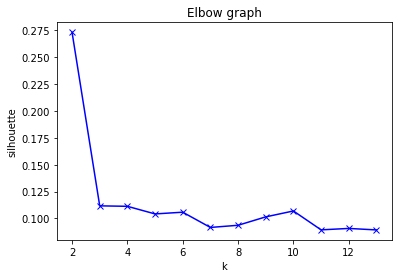

In [18]:
silhouette = []
for k in models.keys():
    silhouette.append(models[k].get('silhouette_score'))
    
# Plot the elbow
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('Elbow graph')
plt.show()

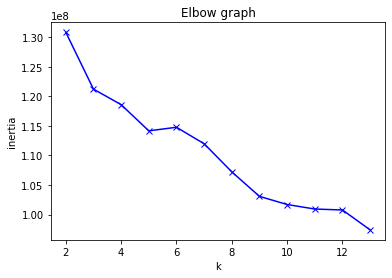

In [19]:
inertia = []
for k in models.keys():
    inertia.append(models[k].get('inertia'))
    
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow graph')
plt.show()

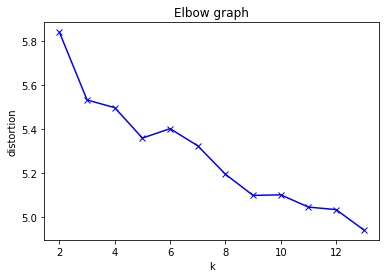

In [20]:
distortion = []
for k in models.keys():
    distortion.append(models[k].get('distortion'))
    
# Plot the elbow
plt.plot(K, distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

In [21]:
models[9].keys()

dict_keys(['distances_to_all_clusters', 'distances_to_nearest_cluster', 'centroids', 'inertia', 'cluster_labels', 'distortion', 'silhouette_score'])

In [22]:
np.shape(df_reduced)

(3164044, 37)

Automatically created module for IPython interactive environment
(547912, 38)
(2616132, 38)
For n_clusters = 2 The average silhouette_score is : 0.27336477042338914
(477424, 38)
(1350494, 38)
(1336126, 38)
For n_clusters = 3 The average silhouette_score is : 0.11175015988761754
(1231184, 38)
(1472773, 38)
(456470, 38)
(3617, 38)
For n_clusters = 4 The average silhouette_score is : 0.11132153791308051
(223750, 38)
(499817, 38)
(1173651, 38)
(278809, 38)
(988017, 38)
For n_clusters = 5 The average silhouette_score is : 0.10423221343099216
(8311, 38)
(937026, 38)
(1243308, 38)
(297612, 38)
(15, 38)
(677772, 38)
For n_clusters = 6 The average silhouette_score is : 0.1058383639996431
(13431, 38)
(1121438, 38)
(278073, 38)
(15, 38)
(728393, 38)
(450158, 38)
(572536, 38)
For n_clusters = 7 The average silhouette_score is : 0.0916467961335497
(280500, 38)
(937684, 38)
(416775, 38)
(15, 38)
(841118, 38)
(530186, 38)
(121371, 38)
(36395, 38)
For n_clusters = 8 The average silhouette_score is : 0

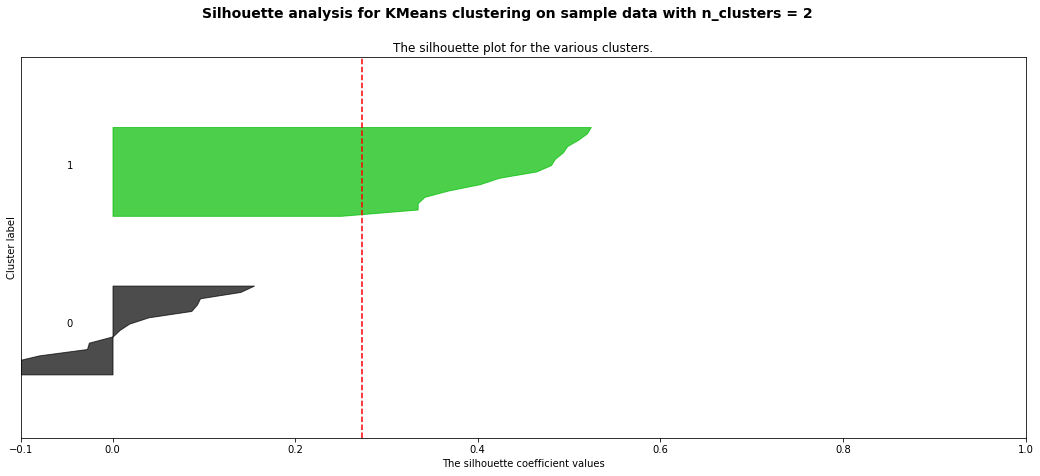

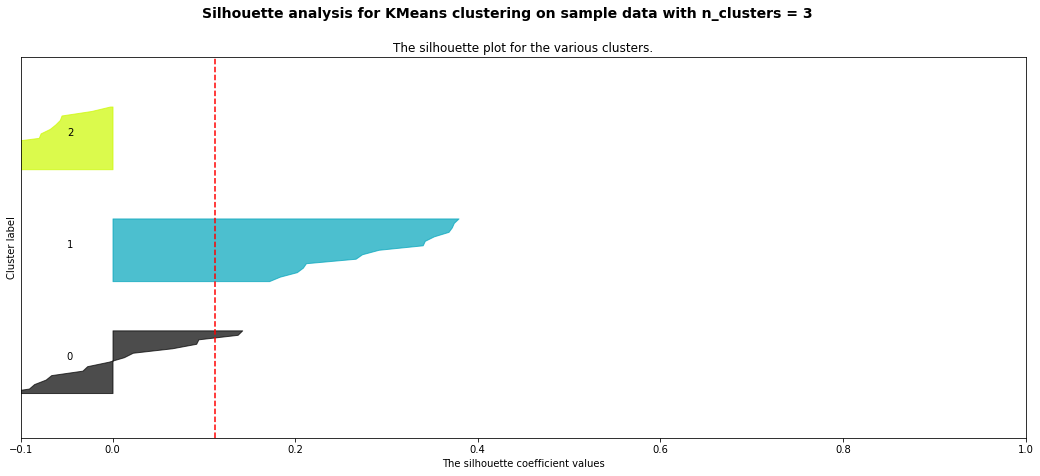

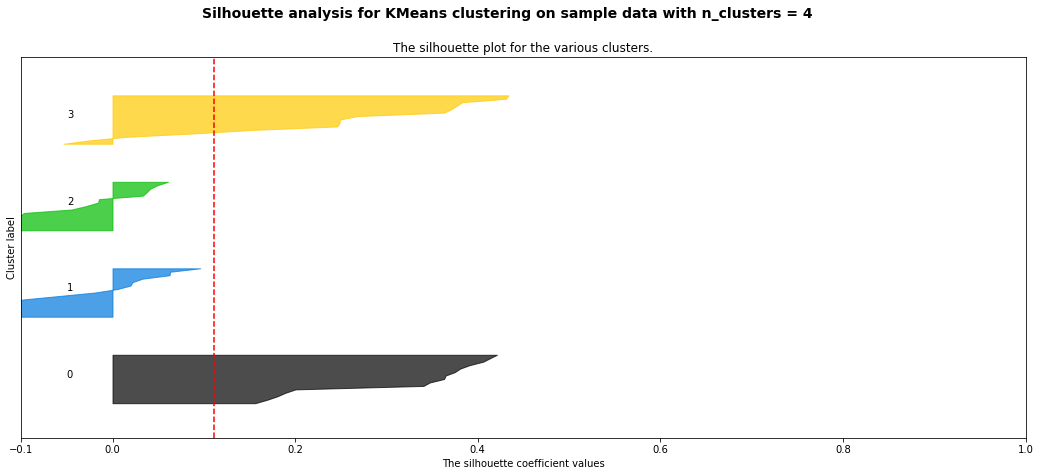

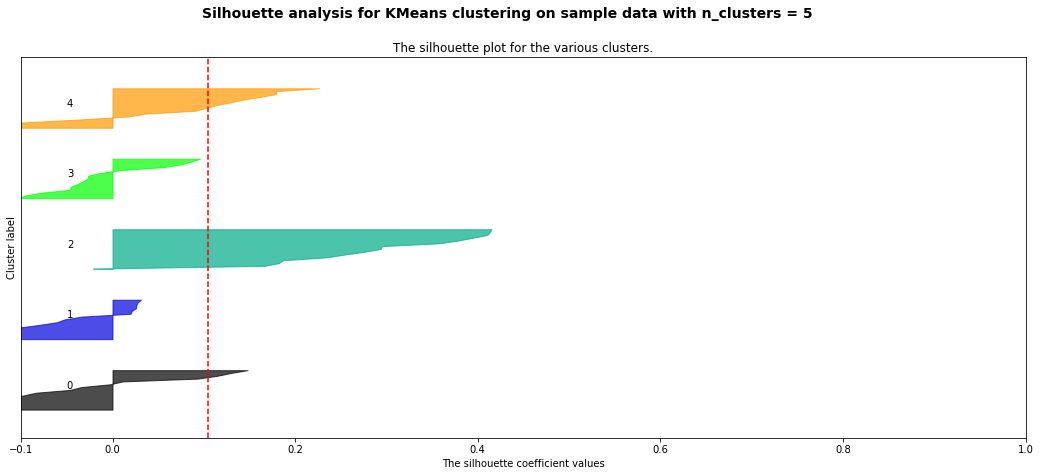

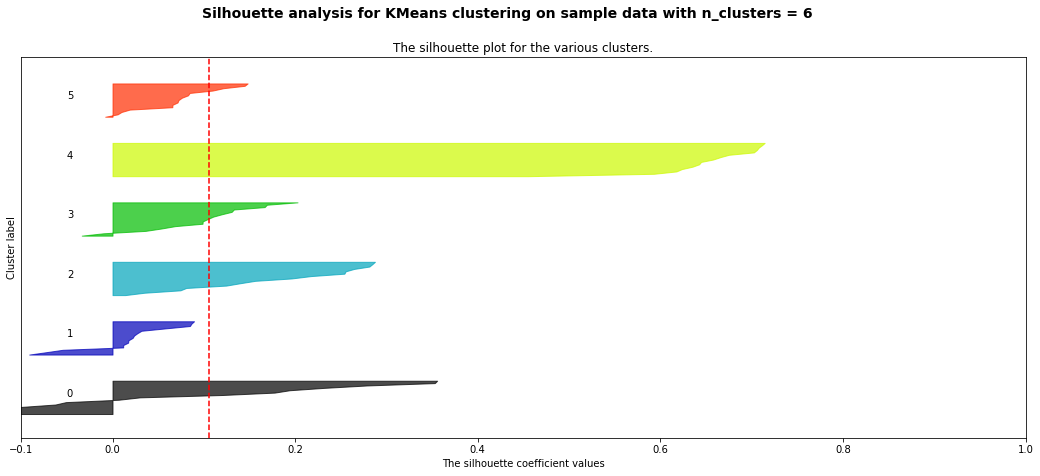

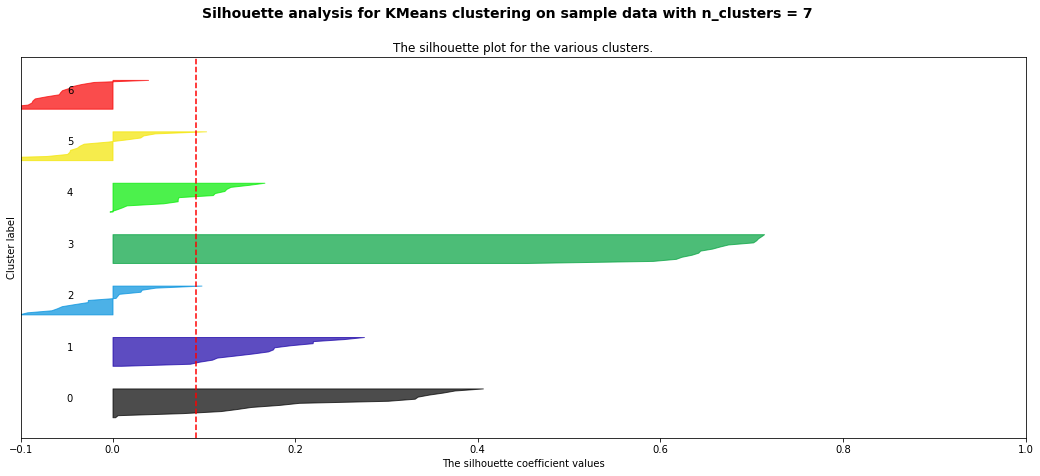

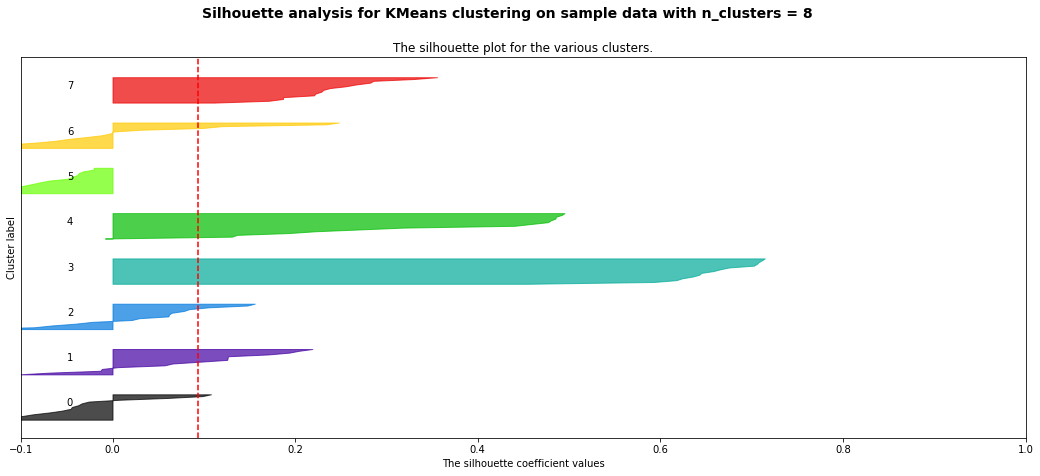

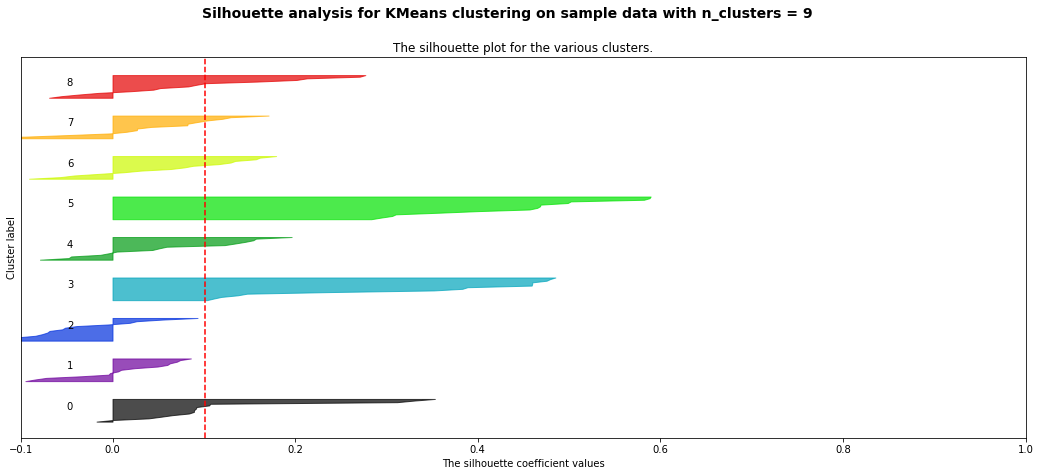

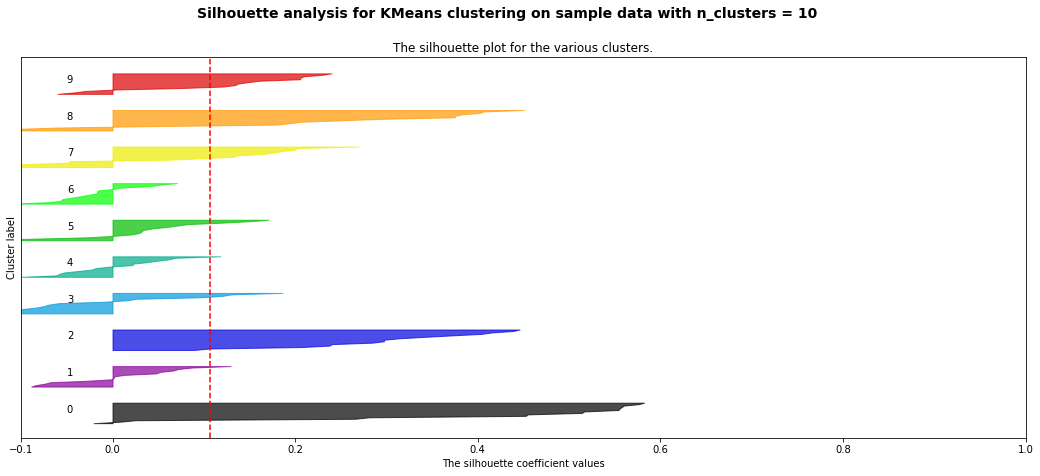

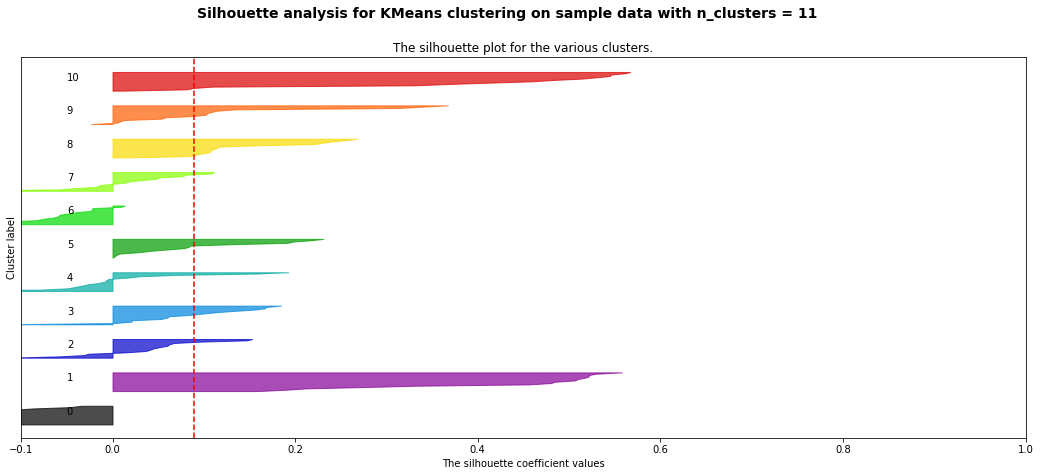

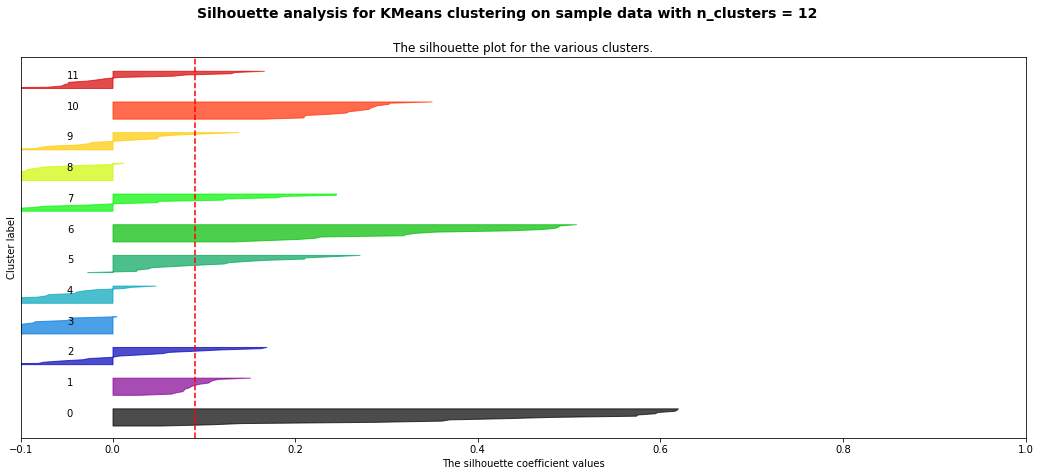

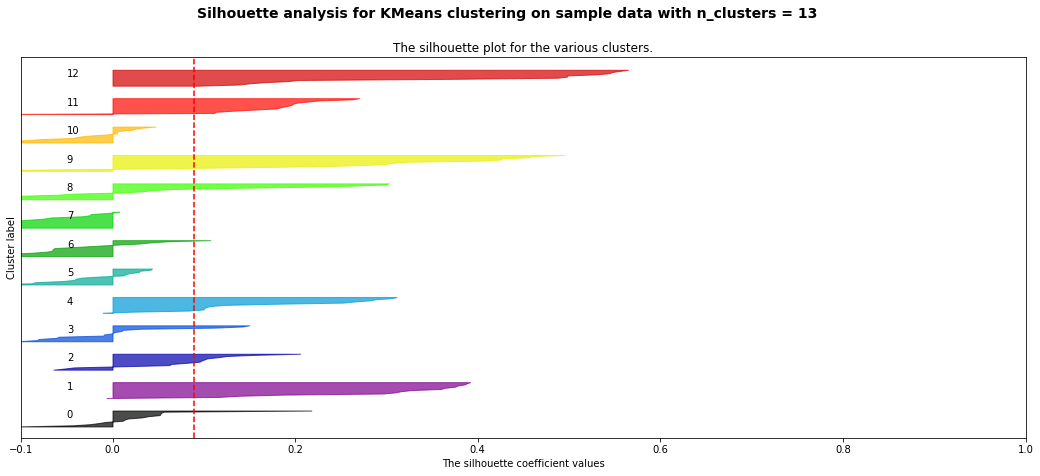

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


range_n_clusters = K
#X = df_reduced
for n_clusters in range_n_clusters:
    
    df_reduced_reduced = np.append(df_reduced, np.transpose([np.array(models[n_clusters].get('cluster_labels'))]), axis=1)
    df_reduced_reduced = pd.DataFrame(df_reduced_reduced)
    df_aux =pd.DataFrame()
    for k in sorted(df_reduced_reduced.iloc[:,-1].unique()):
        print(df_reduced_reduced[df_reduced_reduced.iloc[:,-1]==k].shape)
        df_aux = pd.concat([df_aux, df_reduced_reduced[df_reduced_reduced.iloc[:,-1]==k].sample(n=15, replace=False, random_state=1)])
    cluster_labels = df_aux.iloc[:,-1]
    X = df_aux.drop(df_aux.columns[-1], axis=1)
        
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    #cluster_labels = models[n_clusters].get('cluster_labels')

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = models[n_clusters].get('silhouette_score')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data " "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


range_n_clusters = [9]
#X = df_reduced
for n_clusters in range_n_clusters:
    
    df_reduced_reduced = np.append(df_reduced, np.transpose([np.array(models[n_clusters].get('cluster_labels'))]), axis=1)
    df_reduced_reduced = pd.DataFrame(df_reduced_reduced)
    df_aux =pd.DataFrame()
    for k in sorted(df_reduced_reduced.iloc[:,-1].unique()):
        print(df_reduced_reduced[df_reduced_reduced.iloc[:,-1]==k].shape)
        df_aux = pd.concat([df_aux, df_reduced_reduced[df_reduced_reduced.iloc[:,-1]==k].sample(n=2900, replace=False, random_state=1)])
    cluster_labels = df_aux.iloc[:,-1]
    X = df_aux.drop(df_aux.columns[-1], axis=1)
        
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    #cluster_labels = models[n_clusters].get('cluster_labels')

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = models[n_clusters].get('silhouette_score')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data " "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

"""
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    centers = models[n_clusters].get('centroids')
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
"""
    
plt.show()

In [ ]:
# Análisis de los modelos SIN aplicar PCA

output_folder = 'kmeans-lowlevel-2020-08-29-17-42-30'

#plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
#distortions = []

models ={}

for k in K:
    s3_client = boto3.client('s3')
    key = 'cluster_experiencia/output/' + output_folder +'/' + output_folder + str(k) + '/output/model.tar.gz'
    print(key)
    s3_client.download_file(bucket, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()

    distances_to_all_clusters = cdist(df, kmeans_numpy, 'euclidean')

    distortion = sum(np.min(distances_to_all_clusters, axis=1)) / df.shape[0]
    cluster_labels = np.argmin(distances_to_all_clusters, axis=1)
    # Aquí guardo la distancia al cluster más cercano para cada punto
    cluster_distances = np.min(distances_to_all_clusters, axis=1)
    # Aquí debería calcular el score de Silueta
    silhouette_score = sklearn.metrics.silhouette_score(df, cluster_labels, sample_size =3000, metric='euclidean', random_state=None)
    # Aquí calculo la inercia
    inertia = np.sum(np.power(np.min(cdist(df, kmeans_numpy, 'euclidean'), axis=1), 2))

    dictionary = {
                   'distances_to_all_clusters': distances_to_all_clusters, 
                   'distances_to_nearest_cluster': cluster_distances,
                   'centroids': kmeans_numpy,
                   'inertia': inertia,
                   'cluster_labels': cluster_labels,
                   'distortion': distortion,
                   'silhouette_score': silhouette_score
                  }

    models.update({k: dictionary})

In [ ]:
silhouette = []
for k in models.keys():
    silhouette.append(models[4].get('silhouette_score'))

# Plot the elbow
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('Elbow graph')
plt.show()

In [ ]:
s3_client = boto3.client('s3')
key = 'cluster_experiencia/output/kmeans-lowlevel-2020-08-29-17-42-30/kmeans-lowlevel-2020-08-29-17-42-309/output/model.tar.gz'
print(key)
s3_client.download_file(bucket, key, 'model.tar.gz')
print("Model for k={} ({})".format(9, key))

In [ ]:
!tar -xvf model.tar.gz                       
kmeans_model=mx.ndarray.load('model_algo-1')
kmeans_numpy = kmeans_model[0].asnumpy()

## Selecciono el mejor K y reentreno el modelo para tener el objeto KMeans

In [ ]:
train_data = df.astype('float32')

In [ ]:
from sagemaker import KMeans
prefix = 'cluster_experiencia'
num_clusters=9
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                k=num_clusters,
                output_path='s3://' + bucket + '/' + prefix + '/output_final_model')

In [ ]:
%%time

kmeans.fit(kmeans.record_set(train_data))

In [ ]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

In [ ]:
%%time
result = []
MAX_CHUNK = 20000
for i in range(0,np.shape(train_data)[0], MAX_CHUNK):
    print(i)
    result += kmeans_predictor.predict(train_data[i:i + MAX_CHUNK])
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

In [ ]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

In [ ]:
pd.DataFrame(cluster_labels)[0].value_counts()

In [ ]:
import seaborn as sns

ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title='Histogram of Cluster Counts'
ax.set_title(title, fontsize=32)
plt.show

In [ ]:
model_key = 'cluster_experiencia/output_final_model/kmeans-2020-08-29-18-10-48-597/output/model.tar.gz'

In [ ]:
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

In [ ]:
os.system('tar -zxvf model.tar.gz')

In [ ]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [ ]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())

In [ ]:
cluster_centroids.columns=df_wo_transforms.columns

In [ ]:
cluster_centroids

In [ ]:
plt.figure(figsize = (56,100))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel('Cluster')
plt.yticks(fontsize = 40)
plt.xticks(fontsize = 40)
ax.set_title('Valores de atributos por centroide')
plt.show()

In [ ]:
#sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

In [ ]:
df_wo_transforms['cluster'] = list(map(int, cluster_labels))

In [ ]:
df_wo_transforms['cluster']